# Chapter 2: End to end Machine Learning Project
---
This will follow an example project end to end that shows the ways machine learning can be deployed to answer real life problems.
The steps for a typical projects are as such:
1. Look at the big picture
2. Get the data
3. Explore and visualize the data to gain insights
4. Prepare the data for the algorithms
5. Select a model and train it
6. Fine tune the model
7. Present the solution
8. Launch, monitor and mantain the system

We will be looking at California census data to build a model that will predict housing prices. 

## Step 1. Look at the big picture
The first step in any project will be to ask the questions "What is the ultimate end goal". Whatever model we make is only a tool to help us achieve something meaningful with. If we know what we are workings towards, we can better build a model by knowing what algorithm to use and what performance measures we will evaluate. 

This is called **Framing the problem**

In this case, we are told that we are going to be bringing in census data to predict the average housing price of districts, which will then be used to feed another ML model to determine if that district is worth investing in.

We then ask if there is any current solution to this problem. This helps in seeing what we can compare our solution to as a baseline. Sometimes there might be one and sometimes there might not be. 

With those two piceces of information, we can then start designing our solution. 

The three basic questions to start asking are:
1. What supervesion will this model be? Supervised, unsupervised, semi-supervised, self supervised or reinforcement
2. What type of task is it? Classification, regression or something else?
3. What type of techniques will we use? Batch or online?

For our problem my guess would be that we are dealing with a supervised regression problem. Not so sure on the techniques but I am thinking batch.


Actual answers for the above question
It will be a supervised task, since the model will be trained with labeled examples (we have data on the output that we want to predict)
This will be a regression task, since we are looking to predict a continous value. More specifically it will be multiple regression as we have multiple features
    It is also a univarate regression as we are trying to predict a single output, and not multivariate
Lastly, since the data is not continously being feed in and it is small enough to be stored in-memory, it is a batch learning task


## Step 2. Select a performance measure
There are two common measures that are typically used for regression problems
1. Root Mean Square Error (RMSE) - This one gives higher weights to outliers
2. Mean Absolute error (MAE) - Gives less weight to outliers

When outliers are rare, it is best to use RMSE.

---
Lets bring in our data! Usually data will be stored in databases and must be brought in through them in order to process them. 
In this case we can download data (since it isnt that big) and store it locally, but we can also have a system in place where we can keep data updated by downloading it.
Below will be a function that helps with that.

In [1]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tgz_path = Path("datasets/housing.tgz")
    if not tgz_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url =  "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tgz_path)
        with tarfile.open(tgz_path) as tar_file:
            tar_file.extractall(path="datasets")
    return pd.read_csv("datasets/housing/housing.csv")

housing_data = load_housing_data()

In [2]:
# Take a peek at the data brought in
housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
# Get a description of the data
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Here we are able to see the non null count of each column and their type as loaded in. One of the important things with ML is making the data we plan to use with our model to be as clean as possible for training and testing.
Another thing we notice is a categorical feature in regards to the *ocean_proximity*. We can see how many categories are in the data by using  `value_counts()`

In [4]:
housing_data["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [5]:
# describe() method shoes summary of numerical columns
housing_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


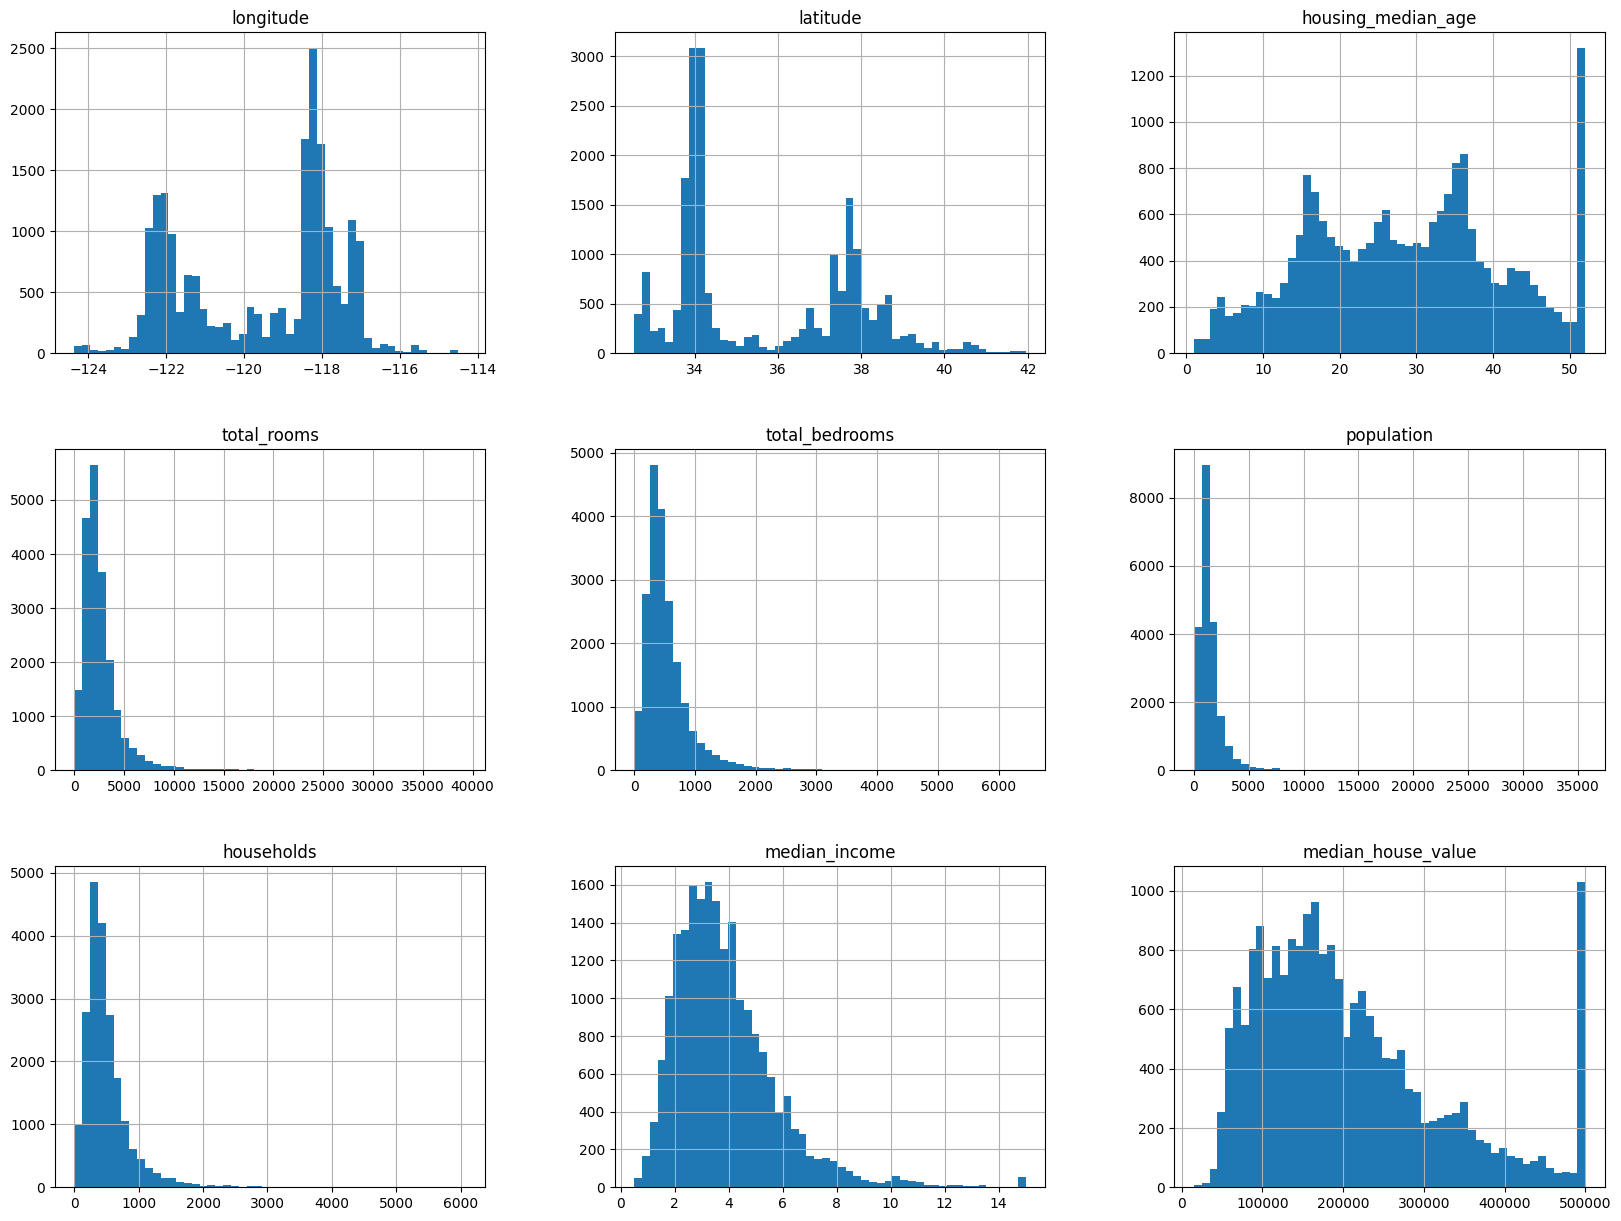

In [6]:
# Another quick way to get a feel for the data is to visualize it. For this example, we will use a historgram
import matplotlib.pyplot as plt

housing_data.hist(bins=50, figsize=(20,15))
plt.show()

Getting to this point of analysing the data as we have, we see a few things:
1. The median income attribute is probably not expressed in straight USD, and we confirm that the number is representing tens of thousands of dollars. We also learn that the values are capped with the minimum capp being 0.5 and the max cap being 15
2. Median house age and house value are also capped. With the house value being our target, the fact that the data has capped values would pose a problem with our model, as it would pick up on the pattern that no house value would ever go over the cap. This can be resolved either by getting data for the uncapped values or by removing those records from our training and testing set
3. These attributes have different scales, which we will learn how to deal with later.
4. We see that a few variables are **skewed right** which can make it hard for some ML algos to detect patterns. We will try transforming these attributes later to get more of a bell curve distribution.

### **It is recommended now to create a test set and put it aside before moving any further**

It may sound strange to voluntarily set aside part of the data at this stage. After
all, you have only taken a quick glance at the data, and surely you should learn
a whole lot more about it before you decide what algorithms to use, right? This
is true, but your brain is an amazing pattern detection system, which also means
that it is highly prone to overfitting: if you look at the test set, you may stumble
upon some seemingly interesting pattern in the test data that leads you to select
a particular kind of Machine Learning model. When you estimate the
generalization error using the test set, your estimate will be too optimistic, and
you will launch a system that will not perform as well as expected. This is
called data snooping bias.


There are many ways to go about making a test data set.
For starters we can simple say we want to take 20% of the data from the whole data set and use that as a test set and the other 80% as training data.
Ideally, we would want to have a way to randomly split the data between these two sets. We would have to consider how to stabilize the split when new data is brought in.
Most of the times this can be achieved by having a imutable identifier that can be used to determine where the data will go.

Purely random sampling can work for large enough datasets (especially relative to the number of features it has) but if it is not, then we run the risk of introducing sampling bias.
An alternative is stratified sampling, where we divide the data into homogenous subgroups and we get the right number of samples from each subgroup to get a test set that best represents the overall data.


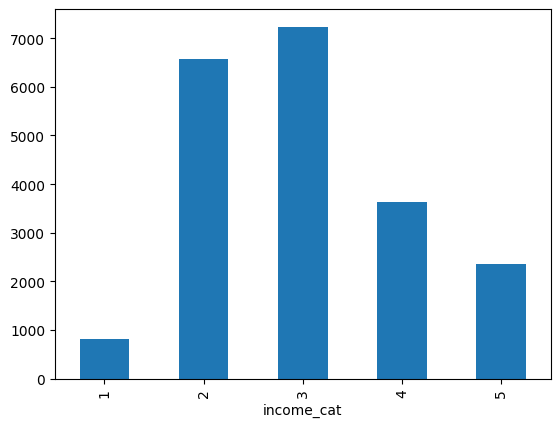

In [7]:
import numpy as np

# Add a new column to housing_data: housing_income_cat
housing_data["income_cat"] = pd.cut(housing_data["median_income"], 
                                    bins=[0, 1.5, 3.0, 4.5, 6.0, np.inf],
                                    labels=[1, 2, 3, 4, 5])  

# Make a bar plot of the new column
housing_data["income_cat"].value_counts().sort_index().plot(kind="bar")
plt.show()

Now that we have categories, we can split the data using stratisfied sampling.
We can use scikit-learn's model selection module for different split methods

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

split = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in split.split(housing_data, housing_data["income_cat"]):
    strat_train_set_n = housing_data.loc[train_index]
    strat_test_set_n = housing_data.loc[test_index]
    strat_splits.append((strat_train_set_n, strat_test_set_n))

# A shortcut for the above would be
strat_train_set, strat_test_set = train_test_split(housing_data, test_size=0.2, random_state=42, stratify=housing_data["income_cat"])

# Lets see the data
strat_test_set["income_cat"].value_counts()

income_cat
3    1447
2    1316
4     728
5     472
1     165
Name: count, dtype: int64

In [9]:
# We wont be using the new category moving forward now, as it was meant to help us split the data.
# Let us revert the data to the original
for set in (strat_train_set, strat_test_set):
    set.drop("income_cat", axis=1, inplace=True)

## Step 3. Discover and visualize the data to gain insights
We will now be going a bit more in depth with our **training data** only. We will put aside our test data and not manipulate it.
We will be performing a bit of experimentation with different transformations so it is a good idea to make a copy of the original data to revert back later.
A good thing to note is that with large datasets we will often have to create a exploration set to better explore the data, since manipulating a large data set would take a lot more time.

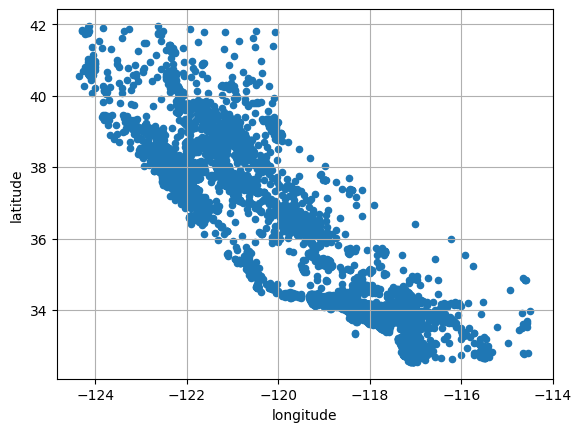

In [10]:
housing = strat_train_set.copy()

# Since there is geographical data, we should plot that with a scatterplot of longitude and latitude

housing.plot(kind="scatter", x="longitude", y="latitude", grid=True)
plt.show()

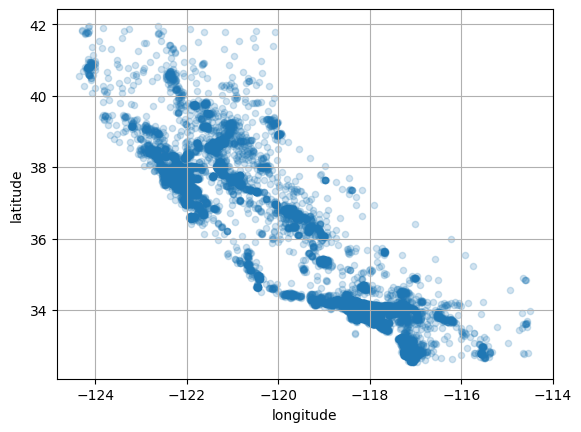

In [11]:
# We should make the data points more visible to pick out areas of high density
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
plt.show()

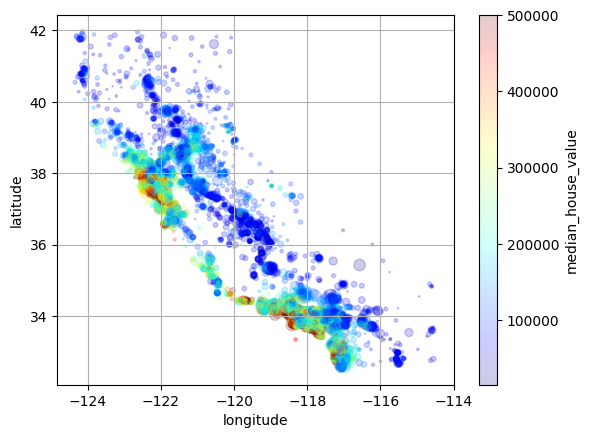

In [12]:
# Lets look at the housing prices on the scatter plot
housing.plot(kind="scatter", x="longitude", y="latitude", c="median_house_value", s=housing["population"]//100, cmap=plt.get_cmap("jet"), colorbar=True, grid=True, alpha=0.2)
plt.show()

In [ ]:
# Since the dataset isnt that large we can get the correlation matrix
corr_matrix = housing.corr(numeric_only=True)

# And lets looks at the data with the values descending
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

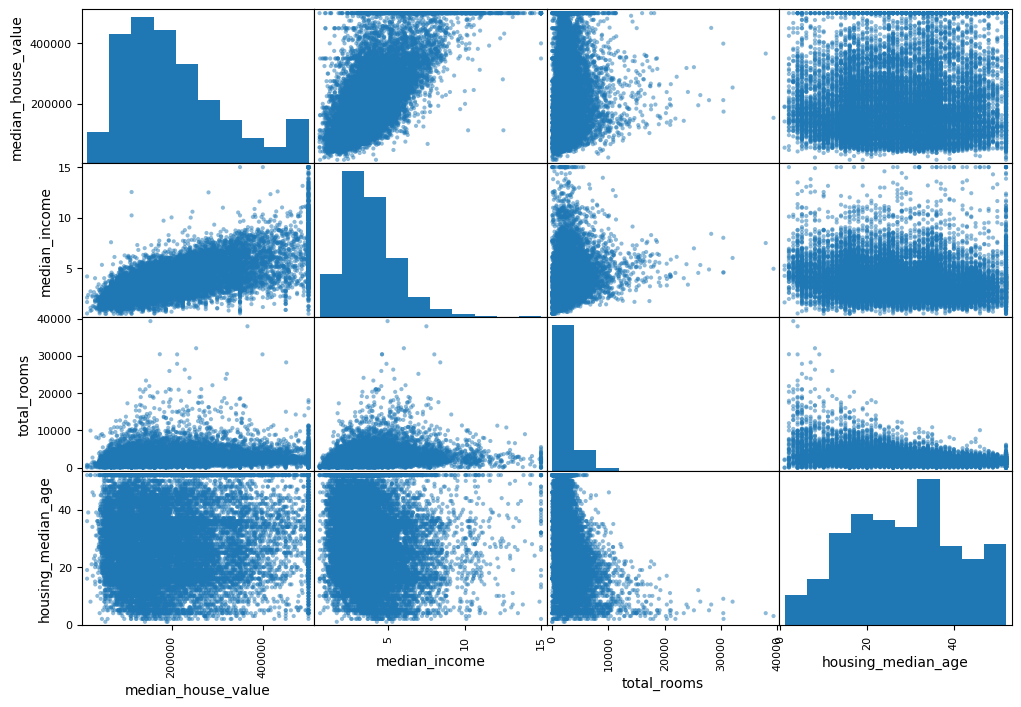

In [14]:
# We can also use the pandas scatter matrix to see possible correlation

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]

pd.plotting.scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

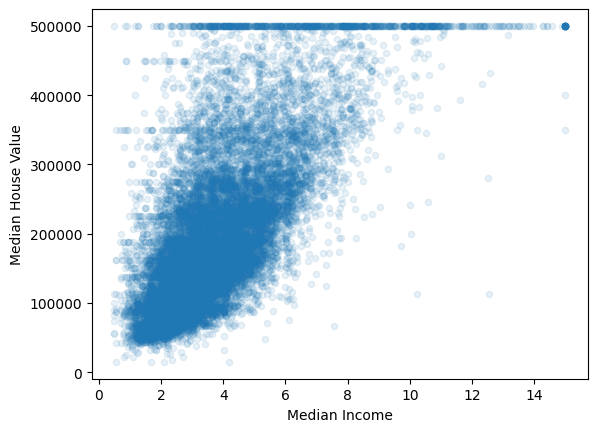

In [15]:
# the most promising feature is the median income
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)
plt.xlabel("Median Income")
plt.ylabel("Median House Value")
plt.show()

When we zoom in to data like this we can see more patterns in detail. In this case, we see that there are lines at the top due to a cap in the data.
We can also see lines in the data at $450k, $380k, and maybe around $240k
These methods of data exploration help us improve our models by cleanin up the data

Another method to better explore the data is to create attribute combinations. These could help in providing more meaningful data.
For example, in this housing data we have the data of total rooms per district, but it might be better to see the rooms per household instead.

In [16]:
# Add three new attributes, which we will call rooms_per_household, bedrooms_per_room, and people_per_household
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_rooms"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_household"] = housing["population"] / housing["households"]

# Lets look at the correlation matrix again
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value      1.000000
median_income           0.688380
rooms_per_household     0.143663
total_rooms             0.137455
housing_median_age      0.102175
households              0.071426
total_bedrooms          0.054635
population             -0.020153
people_per_household   -0.038224
longitude              -0.050859
latitude               -0.139584
bedrooms_per_rooms     -0.256397
Name: median_house_value, dtype: float64

## Step 3. Prepare the data for ML Algorithms
A great thing to do is to build a library of functions to prepare data for your algorithms. We can benefit from easily reusing transformations on new data, for using them on live data, and for quickly trying different combos of transformation.

But first lets revert back our data

In [17]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

### Lets clean some data
ML algorithms do not work well with missing features, so some typical cleaning done is clearing missing data. 
Luckily DataFrames has some functions that help us clean up depending on how destructive we want to be
1. Getting rid of the districts with missing features
2. Getting rid of that feature as a whole
3. Replacing missing values with some other value (0, mean, median, etc)

We will apply the 3rd option and we will apply create an Imputer from scikit-learn. This will allow us to get data in missing feature for our test, validation, and training set. 

In [18]:
from sklearn.impute import SimpleImputer

# Create a imputer
imputer = SimpleImputer(strategy="median")

# create a copy of housing dataset with numeric columns only
housing_num = housing.drop("ocean_proximity", axis=1)

# Fit the imputer on the numeric columns
imputer.fit(housing_num)

# Impute the missing values
X = imputer.transform(housing_num)

# Create a new dataframe with the imputed values
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing.index)
housing_tr.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-119.573125,35.637746,28.577156,2639.402798,537.881298,1425.513929,499.990189,3.870428
std,2.000624,2.133294,12.585738,2185.287466,421.831667,1094.795467,382.865787,1.891936
min,-124.350000,32.550000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900
25%,-121.800000,33.930000,18.000000,1447.000000,297.000000,787.000000,279.000000,2.562500
50%,-118.510000,34.260000,29.000000,2125.000000,434.000000,1167.000000,408.000000,3.538500
75%,-118.010000,37.720000,37.000000,3154.000000,642.000000,1726.000000,603.000000,4.750000
max,-114.490000,41.950000,52.000000,39320.000000,6210.000000,16305.000000,5358.000000,15.000100


### Dealing with text and categorical features.
Our algorithms typically like working with numbers most of the time. So what are some things to think about when handling this?

We can transform the values (if we know it is categorical text) into ordinal values.

In [19]:
# Use scikit-learn's OrdinalEncoder to encode ocean_proximity
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()

housing_cat = housing[["ocean_proximity"]]

housing_cat_encoded = encoder.fit_transform(housing_cat)

# Create a new dataframe with the encoded values
housing_cat_tr = pd.DataFrame(housing_cat_encoded, columns=["ocean_proximity"], index=housing.index)    

There is also another scikit learn class that can encode smartly and efficiently, both computationally and with time, with the OneHotEcoder class

In [20]:
# Creat a one-hot encoder
from sklearn.preprocessing import OneHotEncoder

encoder_oh = OneHotEncoder()

housing_cat_1hot = encoder_oh.fit_transform(housing_cat)

# Create a new dataframe with the encoded values

## Feature scaling and transformation
One of the important transformations we will need to make sure to do with our data is feature scaling.
Most algorithms do not work well when numerical attributes are not on the same scale.
There are two ways we can fix this, either min-max scaling (normalization) or standardization.

Lets look at the simplest method first: Normalization
This usually involes transforming a number so it fits a range, say from 0 to 1
scikit-learn has a transformer for this called MinMaxScaler and we can also set the range we would want it to transform numbers to

In [21]:
from sklearn.preprocessing import MinMaxScaler

# Create a min-max scaler with range -1 to 1
min_max_scaler = MinMaxScaler(feature_range=(-1, 1))

# Create a copy of housing dataset with scaled values
housing_num_scaled = min_max_scaler.fit_transform(housing_num)

The other option is Standardization, which is less affected by outliers in the data
The process of standardization is as follows: subtract the mean value, then divides the result by the std deviation
Scikit-learn also has a transformer for this

In [22]:
from sklearn.preprocessing import StandardScaler

# Create a standard scaler
standard_scaler = StandardScaler()

# Create a copy of housing dataset with scaled values
housing_num_std = standard_scaler.fit_transform(housing_num)

One thing to notice in our data is when there are cases of *heavy tail*, where values far from the mean are not exponentially rare. 
This skewness, or tails in the data, are not handled well when scaling. 
We must take care in transforming these numbers to something that gives us close to a normal distribution as ML models dont like these types of distributions in the data as well.
One way we can do this is if for a positive (right skew) we would replace that feature with the square root of its values.
In our example the population feature is a more extreme example of the above (power law distribution) so here it is better to get the logarithm.
Another approach would be to bucketize the feature, which involves chopping its distribution into equally sized buckets.

When dealing with multimodal distributions (eg. data that has two or more distinct peaks in the distribution) it can be very helpful to bucketize.
The difference will come with the fact that we would treat the buckets as categorical, instead of numerical. This means we would also have to encode this feature as we did with ocean_proximity.
Another way to transform these distributions would be to create another feature that measures the similarity between one of the modes and the feature it is.
In our example we would measure the similarity between housing median age and the mode at 35.
This similarity is calculated with a Radial Basis Function (RBF), which the most common one is the Gaussian RBF. Scikit-learn has something we can use to calculate this.


In [23]:
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=1)

We've so far only dealt with transforming the features, but what about the target value?
If we were to do this, we would have to consider the fact that if we were, for example, transform the median house value to its log, then the model we use will predict the log and not the actual value.
We would need to compute the exponential of this value, OR use methods and classes that scikit learn provides to make this easier.

In [24]:
from sklearn.linear_model import LinearRegression

# The first example is more manual
# Create a standard scaler then fit and transform the housing labels
scaled_labels = standard_scaler.fit_transform(housing_labels.to_frame()) 

# Create a linear regression model and fit it with the scaled labels. In this example we just train it on one feature
lin_reg = LinearRegression()    
lin_reg.fit(housing[["median_income"]], scaled_labels)

some_new_data = housing[["median_income"]].iloc[:5]
scaled_predictions = lin_reg.predict(some_new_data)
predictions = standard_scaler.inverse_transform(scaled_predictions)



In [25]:
from sklearn.compose import TransformedTargetRegressor
# The second example is more compact

model = TransformedTargetRegressor(regressor=LinearRegression(), transformer=standard_scaler)
model.fit(housing[["median_income"]], housing_labels)

new_preds = model.predict(some_new_data)    # This data is not the transformed but the actual data


### Custome transformers
Scikit-learn already provides a lot of useful transformers, but what if need to write a custom one?
We can write transformers that do and do not need to be trained, lets look at an example where we do not need to train

In [26]:
# We will create a function that will log-transform the values we pass in

from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)    # inverse_func is optional and in this case we can see how this benefits having it set
log_pop = log_transformer.transform(housing[["population"]])
log_pop

,population
13096,7.362645
14973,6.501290
3785,6.331502
14689,7.520235
20507,7.555905
...,...
14207,6.843750
13105,7.257708
19301,7.942362
19121,7.452982


In [27]:
# These transformation functions can also take in hyperparameters
# Lets recreate the gaussian rbf similarity function

rbf_transformer = FunctionTransformer(rbf_kernel, kw_args={"Y": [[35]], "gamma": 0.1})

age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])
age_simil_35

array([[2.81118530e-13],
       [8.20849986e-02],
       [6.70320046e-01],
       ...,
       [9.55316054e-22],
       [6.70320046e-01],
       [3.03539138e-04]], shape=(16512, 1))

Also note that rbf_kernel() does not treat the features separately. If you pass it
an array with 2 features, it will measure the 2D distance (Euclidean) to measure
similarity. For example, here’s how to add a feature that will measure the
geographic similarity between each district and San Francisco:

In [28]:
sf_coords = 37.7749, -122.41
sf_transformer = FunctionTransformer(rbf_kernel, kw_args={"Y": [sf_coords], "gamma": 0.1})
sf_simil = sf_transformer.transform(housing[["latitude", "longitude"]])
sf_simil

array([[0.999927  ],
       [0.05258419],
       [0.94864161],
       ...,
       [0.00388525],
       [0.05038518],
       [0.99868067]], shape=(16512, 1))

Lets look at examples where we would want to train our transformers. This involves building a custom class that adheres to scikit-learns api.
In this case, we would need to create a class that implements the fit(), transform(), and fit_transform() methods.
We can shorcut this creation by inheriting from TransformerMixin as a base class.
we can set ourselves up for automatic hyperparameter tuning by also inheriting from BaseEstimator (we would need to avoid having *args and **kargs in the constructor with this)

In [29]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):
        self.with_mean = with_mean 

    def fit(self, X, y=None):
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]    # Every estimator stores this in fit()
        
        return self                         # Always need to return self
    
    def transform(self, X):
        check_is_fitted(self)               # Looks for learned attributes (with trailing _)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        
        return X / self.scale_

Some things to note
- The sklearn.utils.validation package contains several
functions we can use to validate the inputs. For simplicity, we will skip
such tests in the rest of this book, but production code should have
them.

- Scikit-Learn pipelines require the fit() method to have two
arguments X and y, which is why we need the y=None argument even
though we don’t use y.

- All Scikit-Learn estimators set n_features_in_ in the fit()
method, and they ensure that the data passed to transform() or
predict() has this number of features.

- The fit() method must return self

- This implementation is not 100% done. It needs to set feature_names_in_ in fit() if it is passed a DataFrame. It also needs to implement a get_features_names_out method and inverse_transform() when the transformation can be reversed.

A custom transformer can (and often does) use other estimators within it. Lets look at an example that uses KMeans clusterer to identify main clusters in the training data and then uses rbf_kernel() to measure how similar each sample is to each cluster center.

In [50]:
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=0.1, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state
    
    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(n_clusters=self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self
    
    def transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"cluster {i} similarity" for i in range(self.n_clusters)]

In [51]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]], sample_weight=housing_labels)

similarities[:3].round(2)

array([[0.  , 0.98, 0.  , 0.  , 0.  , 0.  , 0.13, 0.55, 0.  , 0.56],
       [0.64, 0.  , 0.11, 0.04, 0.  , 0.  , 0.  , 0.  , 0.99, 0.  ],
       [0.  , 0.65, 0.  , 0.  , 0.01, 0.  , 0.49, 0.59, 0.  , 0.28]])

### Transformation Pipelines
Pipelines are a way to make sure every data transformation step is done in the correct order. It makes managing multi step transformations for various models easier as we can record the steps we want taken.

In [52]:
from sklearn.pipeline import Pipeline

# Create a pipeline with a simple imputer and a standard scaler
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

A pipeline takes in a list of name/estimator pairs. We can have whatever name we want in the pairs.
The inputs must all be estimators besides the last one in the line, which can be a transformer, a predictor, or any other type of estimator

In [53]:
import sklearn
sklearn.set_config(display="diagram")

In [54]:
num_pipeline

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())])

In [55]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
df_housing_num_prepared = pd.DataFrame(housing_num_prepared, columns=num_pipeline.get_feature_names_out(), index=housing_num.index)
df_housing_num_prepared.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04
mean,-4.837216e-15,-2.580838e-15,-1.473843e-17,-5.916886e-17,1.039220e-16,4.765783e-17,1.463085e-17,7.611267e-17
std,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00
min,-2.387765e+00,-1.447452e+00,-2.191210e+00,-1.206927e+00,-1.272777e+00,-1.299382e+00,-1.303343e+00,-1.781577e+00
25%,-1.113124e+00,-8.005453e-01,-8.404335e-01,-5.456668e-01,-5.710538e-01,-5.832443e-01,-5.772176e-01,-6.913383e-01
50%,5.314128e-01,-6.458502e-01,3.359809e-02,-2.354008e-01,-2.462699e-01,-2.361370e-01,-2.402747e-01,-1.754490e-01
75%,7.813423e-01,9.761041e-01,6.692575e-01,2.354897e-01,2.468327e-01,2.744761e-01,2.690575e-01,4.649198e-01
max,2.540847e+00,2.959014e+00,1.861119e+00,1.678576e+01,1.344681e+01,1.359152e+01,1.268893e+01,5.882868e+00


Pipelines support indexing, so we can access them as arrays. We can of course also access them as dictionaries `num_pipeline["imputer"]`

So far we have been cleaning the categorical and numerical features seperately but it would be more convinient for having one transformer to handle this.
For this we can use a ColumnTransformer.

In [56]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs)
])

In the above example we create a list of 3-tuples with a name, the transformer, and the columns to apply the transformations to.

scikit-learn provides a more automatic way to select columns with the make_column_selector(). The alternative, if naming is not important, is to use make_column_transformer()

In [57]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include="float64")),
    (cat_pipeline, make_column_selector(dtype_include="object"))
)

In [58]:
# Now to make one call to prepare the housing data
housing_prepared = preprocessing.fit_transform(housing)

# Make a dataframe out of the prepared data
df_housing_prepared = pd.DataFrame(housing_prepared, columns=preprocessing.get_feature_names_out(), index=housing.index)

df_housing_prepared.head()

,pipeline-1__longitude,pipeline-1__latitude,pipeline-1__housing_median_age,pipeline-1__total_rooms,pipeline-1__total_bedrooms,pipeline-1__population,pipeline-1__households,pipeline-1__median_income,pipeline-2__ocean_proximity_<1H OCEAN,pipeline-2__ocean_proximity_INLAND,pipeline-2__ocean_proximity_ISLAND,pipeline-2__ocean_proximity_NEAR BAY,pipeline-2__ocean_proximity_NEAR OCEAN
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491,0.0,0.0,0.0,1.0,0.0
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942,1.0,0.0,0.0,0.0,0.0
3785,-1.203098,1.276119,0.351428,-0.712240,-0.760709,-0.788768,-0.775727,-0.759789,0.0,1.0,0.0,0.0,0.0
14689,1.231216,-0.884924,-0.919891,0.702262,0.742306,0.383175,0.731375,-0.850281,0.0,1.0,0.0,0.0,0.0
20507,0.711362,-0.875549,0.589800,0.790125,1.595753,0.444376,1.755263,-0.180365,0.0,0.0,0.0,0.0,1.0


In [59]:
df_housing_prepared.describe()

,pipeline-1__longitude,pipeline-1__latitude,pipeline-1__housing_median_age,pipeline-1__total_rooms,pipeline-1__total_bedrooms,pipeline-1__population,pipeline-1__households,pipeline-1__median_income,pipeline-2__ocean_proximity_<1H OCEAN,pipeline-2__ocean_proximity_INLAND,pipeline-2__ocean_proximity_ISLAND,pipeline-2__ocean_proximity_NEAR BAY,pipeline-2__ocean_proximity_NEAR OCEAN
count,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-4.837216e-15,-2.580838e-15,-1.473843e-17,-5.916886e-17,1.039220e-16,4.765783e-17,1.463085e-17,7.611267e-17,0.440528,0.321039,0.000121,0.111797,0.126514
std,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,0.496466,0.466890,0.011005,0.315127,0.332438
min,-2.387765e+00,-1.447452e+00,-2.191210e+00,-1.206927e+00,-1.272777e+00,-1.299382e+00,-1.303343e+00,-1.781577e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-1.113124e+00,-8.005453e-01,-8.404335e-01,-5.456668e-01,-5.710538e-01,-5.832443e-01,-5.772176e-01,-6.913383e-01,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.314128e-01,-6.458502e-01,3.359809e-02,-2.354008e-01,-2.462699e-01,-2.361370e-01,-2.402747e-01,-1.754490e-01,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.813423e-01,9.761041e-01,6.692575e-01,2.354897e-01,2.468327e-01,2.744761e-01,2.690575e-01,4.649198e-01,1.000000,1.000000,0.000000,0.000000,0.000000
max,2.540847e+00,2.959014e+00,1.861119e+00,1.678576e+01,1.344681e+01,1.359152e+01,1.268893e+01,5.882868e+00,1.000000,1.000000,1.000000,1.000000,1.000000


### Putting everything together

Lets go over exactly what we want our pipeline to do
- Missing numerical features will be imputed by replacing those values with the median. Categorical features will be replaced by the most frequent category
- Categorical features will be one-hot encoded
- A few ratio features will be computed: bedrooms_ratio, rooms_per_household, people_per_house
- Few cluster similarity features will be added
- Features with a long tail will be replaced with their logarithm
- All numerical features will be standardized.

Lets put this into code

In [66]:
# Make a function that will calculate the ratio between two columns
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

# Make a function that will return a pipeline that applies the column_ratio function on the named columns provided
def ratio_pipeline(name=None):
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=lambda input_features1, input_features2: [name]),
        StandardScaler()
    )

# Make a pipeline that applies the logarthmic transformation
log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler()
)

# Make a pipeline that applies the rbf similarity function to get geospatial clustering
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)

# Make a pipeline that applies a basic standard scaler
default_num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

# Creathe the whole column transformer
preprocessing = ColumnTransformer([
    ("bedrooms_ratio", ratio_pipeline("bedrooms_ratio"), ["total_bedrooms", "total_rooms"]),
    ("rooms_per_house", ratio_pipeline("rooms_per_house"), ["total_rooms", "households"]),
    ("pop_per_house", ratio_pipeline("pop_per_house"), ["population", "households"]),
    ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population", "households"]),
    ("geo", cluster_simil, ["latitude", "longitude"]),
    ("cat", cat_pipeline, make_column_selector(dtype_include="object")),
], remainder=default_num_pipeline)



In [67]:
housing_prepared = preprocessing.fit_transform(housing)

In [68]:
preprocessing.get_feature_names_out()

array(['bedrooms_ratio__bedrooms_ratio',
       'rooms_per_house__rooms_per_house', 'pop_per_house__pop_per_house',
       'log__total_bedrooms', 'log__total_rooms', 'log__population',
       'log__households', 'geo__cluster 0 similarity',
       'geo__cluster 1 similarity', 'geo__cluster 2 similarity',
       'geo__cluster 3 similarity', 'geo__cluster 4 similarity',
       'geo__cluster 5 similarity', 'geo__cluster 6 similarity',
       'geo__cluster 7 similarity', 'geo__cluster 8 similarity',
       'geo__cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age', 'remainder__median_income'],
      dtype=object)

## Step 3: Select and Train a Model
So up to this point we have framed the problem (we want to predict the median home value), got the data and explored it, sampled a training and testing set, and we have written a preprocessing pipeline to automatically prepare the data for the ML algorithms. We are now ready to select a model to train!

Thanks to all the previous steps the next ones are very easy. We decide for now to train a basic Linear Regression model to get started

In [69]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())

lin_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms_ratio',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_pipel...
                                                   'households']),
                                                 ('geo',
                                                  ClusterSimilarity(gamma=1.0,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002AD1A3D0550>)])),
                ('linearregression', LinearRegression())])

In [71]:
# We now have a working linear regression model. Lets run some predections and show the first five results
housing_predictions = lin_reg.predict(housing)
housing_predictions[:5].round(-2)

array([259500., 377200., 128100.,  95700., 324800.])

In [72]:
housing_labels.iloc[:5].values

array([458300., 483800., 101700.,  96100., 361800.])

In [75]:
# Lets measure the rmse 
from sklearn.metrics import root_mean_squared_error
lin_rnsme = root_mean_squared_error(housing_labels, housing_predictions)
lin_rnsme

64477.924062324666

This is better than anything, but the values of houses range from $125k to $250k so a prediction off by $60k doesnt seem that good.
So how can we improve the rmse? 
1. Use a more complex model
2. Feed the model better feature
3. Reduce the constraints on the model

The linear regression model is not normalized so the last option is out.
Lets first try using a different model. In this case lets check out a decision tree

In [76]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

housing_predictions = tree_reg.predict(housing)
tree_rmse = root_mean_squared_error(housing_labels, housing_predictions)
tree_rmse

0.0

Wait, what!? No error at all? Could this model really be absolutely perfect? Of
course, it is much more likely that the model has badly overfit the data. How
can you be sure? As we saw earlier, you don’t want to touch the test set until
you are ready to launch a model you are confident about, so you need to use
part of the training set for training and part of it for model validation.

### Better evaluation using cross validation
We could split the training set into a smaller training and validation set and train the model on the smaller training set and then eval on the smaller validation set.
A great alternative to this would be to use scikit-learns K-fold cross-validation feature.
This randomly splits the training set into x number of non-overlapping subsets called folds, then it trains and evaluates the model for x times, pickingg a different fold each time to evaluate and then train using the left over folds. The result is an array containing the eval scores.

In [78]:
from sklearn.model_selection import cross_val_score

# For this example lets do a 10 fold cross validation
tree_rmses = -cross_val_score(tree_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10)
pd.Series(tree_rmses).describe()

count       10.000000
mean     66548.395105
std       1350.167224
min      64519.329832
25%      65351.960239
50%      67045.494643
75%      67490.198737
max      68616.604906
dtype: float64

We can see that the decision tree model is not that much better than the linear regression model. In fact with the cross-validation method we can better see the accuracy of the model through the results standard deviation. 
We know the scores of the decision tree are "better" because of severe overfitting, since the training error is low (actually zero in this case) and the validation error is high.

Lets quickly try a random forest model. We will go in more details later about this model.

In [79]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10)  
pd.Series(forest_rmses).describe()

count       10.000000
mean     47045.220083
std       1041.694969
min      45695.100754
25%      46494.636106
50%      47018.343319
75%      47372.653758
max      49373.941742
dtype: float64

Wow, this is much better: Random Forests really look very promising for this
task! However, if you train a RandomForest and measure the RMSE on the
training set, you will find about 17,474: that’s much lower, meaning that there’s
still quite a lot of overfitting going on. Possible solutions are to simplify the
model, constrain it (i.e., regularize it), or get a lot more training data. Before
you dive much deeper into Random Forests, however, you should try out many
other models from various categories of Machine Learning algorithms (e.g.,
several Support Vector Machines with different kernels, and possibly a neural
network), without spending too much time tweaking the hyperparameters. The
goal is to shortlist a few (two to five) promising models.


## Step 4: Fine tune the model
Lets assume you have your short list of models. Now we need to fine tune them. Lets look at a few ways you can do that.

### Grid Search
Scikit-learn has a GridSearchCV class to help search. All we need to do is provide it with hyperparameters we want to experiment with and what values to try out. It will use cross-validation to evaluate all the possible combinations.

In [80]:
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('random_forest', RandomForestRegressor(random_state=42))
])

param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
      'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters': [10, 15],
      'random_forest__max_features': [6, 8, 10]}
]

grid_search = GridSearchCV(full_pipeline, param_grid, cv=3, scoring='neg_root_mean_squared_error')
grid_search.fit(housing, housing_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms_ratio',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000002AD1A3D0550>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In [81]:
grid_search.best_params_

# Initiliaze GridSearchCV wiht refit=True, as this will auto apply the better estimar it retrains again on the whole training set

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

In [82]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms_ratio',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_pipeline....
                                                                    n_clusters=15,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002AD1D682FF0>)])),
                ('random_forest',
                 RandomForestRegressor(max_features=6, random_state=42))])

In [83]:
# We can visualize the results better if we use grid_search.cv_results_ and make a dataframe with it.
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessing__geo__n_clusters,param_random_forest__max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
12,6.565468,0.413063,0.112962,0.021474,15,6,"{'preprocessing__geo__n_clusters': 15, 'random...",-42828.886573,-43578.208273,-44414.525362,-43607.206736,647.659003,1
13,5.481227,0.040539,0.084188,0.000985,15,8,"{'preprocessing__geo__n_clusters': 15, 'random...",-43550.254198,-43966.291717,-44785.625738,-44100.723884,513.218417,2
6,2.829298,0.021780,0.083165,0.000733,10,4,"{'preprocessing__geo__n_clusters': 10, 'random...",-43717.146063,-44074.321070,-44847.645681,-44213.037604,471.832636,3
14,6.709341,0.050830,0.084295,0.001357,15,10,"{'preprocessing__geo__n_clusters': 15, 'random...",-43883.567703,-44247.204564,-45031.087140,-44387.286469,478.830116,4
7,4.062596,0.044996,0.087005,0.007238,10,6,"{'preprocessing__geo__n_clusters': 10, 'random...",-44052.949500,-44504.897654,-45118.544433,-44558.797196,436.693646,5
9,6.647372,0.039411,0.128799,0.000989,10,6,"{'preprocessing__geo__n_clusters': 10, 'random...",-44052.949500,-44504.897654,-45118.544433,-44558.797196,436.693646,5
3,2.818342,0.011276,0.082890,0.000632,8,4,"{'preprocessing__geo__n_clusters': 8, 'random_...",-44274.834322,-44521.352655,-45714.359494,-44836.848823,628.602447,7
10,8.579962,0.040620,0.136633,0.006000,10,8,"{'preprocessing__geo__n_clusters': 10, 'random...",-44516.838691,-45110.222593,-45623.008212,-45083.356499,451.991219,8
8,7.924709,0.920418,0.132584,0.002727,10,8,"{'preprocessing__geo__n_clusters': 10, 'random...",-44516.838691,-45110.222593,-45623.008212,-45083.356499,451.991219,8
4,3.922337,0.006281,0.088374,0.008215,8,6,"{'preprocessing__geo__n_clusters': 8, 'random_...",-44811.344200,-44993.038930,-45687.982930,-45164.122020,377.779418,10


Using grid search is fine especially in cases where there are relatively few combinations. 
RansomizedSearchCV is often preferable, especially when there are a lot more combos.
It works by training out a fixed number of combinations, selecting a random value for each hyperparameter. 

In [84]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
    'preprocessing__geo__n_clusters': randint(low=3, high=30),
    'random_forest__max_features': randint(low=2, high=20)
}

rnd_search = RandomizedSearchCV(full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3, scoring='neg_root_mean_squared_error', random_state=42)

rnd_search.fit(housing, housing_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms_ratio',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002AD50A51400>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002AD50B45450>},
                   random_state=42, scoring='neg_root_mean_squared_error')

There are two other hyperparameter searching classes: HalvingRandomSearchCV and HalvingGridsSearchCV
Consider these for very large datasets

### Ensemble Methods
Another way to fine-tune your system is to try to combine the models that
perform best. The group (or “ensemble”) will often perform better than the best
individual model—just like Random Forests perform better than the individual
Decision Trees they rely on—especially if the individual models make very
different types of errors. For example, you could train and fine-tune a k-Nearest
Neighbors model, then create an ensemble model that just predicts the mean of the random forest prediction and the KNN’s prediction.

### Analyze the best models and their errors
You will often learn insights from the problem by inspecting the best models. We can list out the features that are more important to making accurate predections 

In [85]:
final_model = rnd_search.best_estimator_
features_importance = final_model["random_forest"].feature_importances_
features_importance.round(2)

array([0.08, 0.05, 0.06, 0.01, 0.01, 0.01, 0.01, 0.03, 0.02, 0.02, 0.01,
       0.01, 0.01, 0.02, 0.02, 0.02, 0.04, 0.01, 0.01, 0.02, 0.03, 0.02,
       0.01, 0.02, 0.02, 0.03, 0.02, 0.01, 0.01, 0.01, 0.  , 0.11, 0.  ,
       0.  , 0.  , 0.02, 0.23])

In [87]:
sorted(zip(features_importance, final_model["preprocessing"].get_feature_names_out()), reverse=True)

[(np.float64(0.22638261640580482), 'remainder__median_income'),
 (np.float64(0.1056661625511717), 'cat__ocean_proximity_INLAND'),
 (np.float64(0.07660831807719462), 'bedrooms_ratio__bedrooms_ratio'),
 (np.float64(0.06203962244494316), 'pop_per_house__pop_per_house'),
 (np.float64(0.052305939187621456), 'rooms_per_house__rooms_per_house'),
 (np.float64(0.035155119767442095), 'geo__cluster 9 similarity'),
 (np.float64(0.030676419867684327), 'geo__cluster 13 similarity'),
 (np.float64(0.02683887895577976), 'geo__cluster 18 similarity'),
 (np.float64(0.025008363131052702), 'geo__cluster 0 similarity'),
 (np.float64(0.024711294535166375), 'geo__cluster 6 similarity'),
 (np.float64(0.021516988191917764), 'geo__cluster 12 similarity'),
 (np.float64(0.021199357241675987), 'geo__cluster 1 similarity'),
 (np.float64(0.020202663493146488), 'geo__cluster 7 similarity'),
 (np.float64(0.020092627904092816), 'geo__cluster 14 similarity'),
 (np.float64(0.018992927693343528), 'geo__cluster 2 similarity

With this info we can drop less important features and retrain the model.

You should also look at the specific errors that your system makes, then try to
understand why it makes them and what could fix the problem: adding extra
features or getting rid of uninformative ones, cleaning up outliers, etc

Now is also a good time to ensure that your model not only works well on
average, but also on all categories of districts, whether they’re rural or urban,
rich or poor, North or South, minority or not, etc. This requires a bit of work
creating subsets of your validation set for each category, but it’s important: if
your model performs poorly on a whole category of districts, then it should
probably not be deployed until the issue is solved, or at least it should not be
used to make predictions for that category, as it may do more harm than good.


### Evaluate the system on the test set
After tweaking the models for a bit its time to evaluate the final model on the test set.
There is nothing special about this step just get the predictors and labels from the test set and run transform on the final_model() to make predictions 

In [88]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = root_mean_squared_error(y_test, final_predictions)
print(final_rmse)

42515.36994065993


Lets calculate a 95% confidence interval to help use better see if it will be worth pushing this to production.

In [89]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=np.mean(squared_errors), scale=stats.sem(squared_errors)))

array([40377.2100428 , 44551.02997173])

If you did a lot of hyperparameter tuning, the performance will usually be
slightly worse than what you measured using cross-validation. That’s because
your system ends up fine-tuned to perform well on the validation data and will
likely not perform as well on unknown datasets. It is not the case in this
example since the test RMSE is lower than the validation RMSE, but when it
happens you must resist the temptation to tweak the hyperparameters to make
the numbers look good on the test set; the improvements would be unlikely to
generalize to new data.
Now comes the project prelaunch phase: you need to present your solution
(highlighting what you have learned, what worked and what did not, what
assumptions were made, and what your system’s limitations are), document
everything, and create nice presentations with clear visualizations and easy-toremember statements (e.g., “the median income is the number one predictor of
housing prices”). In this California housing example, the final performance of
the system is not much better than the experts’ price estimates which were often
off by 30%, but it may still be a good idea to launch it, especially if this frees up
some time for the experts so they can work on more interesting and productive
tasks.

## Step 5: Launch, monitor, and maintain your system:
Perfect, you got approval to launch! You now need to get your solution ready
for production (e.g., polish the code, write documentation and tests, and so on).
Then you can deploy your model to your production environment. The most
basic way to do this is just to save the best model you trained, transfer the file
to your production environment, and load it. To save the model, you can use the
joblib library like this:


In [ ]:
import joblib
joblib.dump(final_model, "my_california_housing_model.pkl")

# Load back later with joblib.load()

PicklingError: Can't pickle <function ratio_pipeline.<locals>.<lambda> at 0x000002AD50A4F7E0>: it's not found as __main__.ratio_pipeline.<locals>.<lambda>